In [5]:
import json

with open("hits_data.json", "r") as f:
    data = json.load(f)
    
if "eimrail.org" in data:
    print "EIM's website is in there, yeah!"
data

EIM's website is in there, yeah!


{u'food.cloud': {u'hits': 2,
  u'record': {u'digest': u'UCVSQM7B5RU2FPG4EXFOSHM7MO7EIBGH',
   u'filename': u'crawl-data/CC-MAIN-2016-40/segments/1474738660760.0/warc/CC-MAIN-20160924173740-00133-ip-10-143-35-109.ec2.internal.warc.gz',
   u'length': u'9447',
   u'mime': u'text/html',
   u'offset': u'90806581',
   u'status': u'200',
   u'timestamp': u'20160926121043',
   u'url': u'http://food.cloud/',
   u'urlkey': u'cloud,food)/'}},
 u'youthpress.org': {u'hits': 11,
  u'record': {u'digest': u'L4MI7XAZRP6DABQPOP35HSLPGBPC4LBY',
   u'filename': u'crawl-data/CC-MAIN-2016-40/segments/1474738661910.62/warc/CC-MAIN-20160924173741-00029-ip-10-143-35-109.ec2.internal.warc.gz',
   u'length': u'8558',
   u'mime': u'text/html',
   u'offset': u'841974757',
   u'status': u'200',
   u'timestamp': u'20160929183927',
   u'url': u'http://www.youthpress.org/',
   u'urlkey': u'org,youthpress)/'}},
 u'social4social.org': {u'hits': 1,
  u'record': {u'digest': u'A6C4FBBUUY2X7HJBR5KMPTUHB3BQ5MSJ',
   u'filena

In [18]:
from bs4 import BeautifulSoup
import gzip
import requests
import StringIO


# Lets first write three helper functions:

def download_page(record):
    """ Retrieves WARC Files from record. Return the status of the file request"""
    offset, length = int(record['offset']), int(record['length'])
    offset_end = offset + length - 1

    # We'll get the file via HTTPS so we don't need to worry about S3 credentials
    # Getting the file on S3 is equivalent however - you can request a Range
    prefix = 'https://commoncrawl.s3.amazonaws.com/'
    
    # We can then use the Range header to ask for just this set of bytes
    resp = requests.get(prefix + record['filename'], headers={'Range': 'bytes={}-{}'.format(offset, offset_end)})
    
    # The page is stored compressed (gzip) to save space
    # We can extract it using the GZIP library
    raw_data = StringIO.StringIO(resp.content)
    f = gzip.GzipFile(fileobj=raw_data)
    
    # What we have now is just the WARC response, formatted:
    data = f.read()
    
    response = ""
    
    if len(data):
        try:
            warc, header, response = data.strip().split('\r\n\r\n', 2)
        except:
            pass
            
    return response


# Extract links from the HTML  
#
def extract_external_links(html_content,link_list, domain):

    parser = BeautifulSoup(html_content, "html.parser")
        
    links = parser.find_all("a")
    
    if links:
        
        for link in links:
            href = link.attrs.get("href")
            
            if href is not None:
                
                if domain not in href:
                    if href not in link_list and href.startswith("http"):
                        print "[*] Discovered external link: %s" % href
                        link_list.append(href)

    return link_list


# Extract domain form links 
#
def extract_clean_domains(link_list):
    domain_list = []
    
    for link in link_list:
        domain = link.split('/')[2]
        
        if "ww" in domain:
            domain = domain[domain.find('.')+1:]
            
        domain_list.append(str(domain))
        
    return domain_list

In [41]:

for key in data.keys():
    # get the record for each domain
    record = dict(data[key]['record'])
    # We create the link list here in case we want to dowload multiple records for one domain
    link_list = []
    try:
        html_content = download_page(record)
    except:
        html_content = None
        print "No data found for ", key
    # We pass it to the extract function for the same reason: to avoid having doublon
    # link_list = extract_external_links(html_content,link_list,domain)
    if html_content is not None:
        data[key]["links"] = extract_clean_domains(extract_external_links(html_content,link_list, domain=key))
    else:
        data[key]["links"] = []

[*] Discovered external link: http://ie.indeed.com/cmp/Foodcloud/jobs
[*] Discovered external link: https://www.facebook.com/foodcloudireland
[*] Discovered external link: https://plus.google.com/104586320302600540121/about
[*] Discovered external link: https://www.linkedin.com/company/foodcloud
[*] Discovered external link: https://twitter.com/foodcloud
[*] Discovered external link: https://www.youtube.com/channel/UCQevxDsQOjtWd-8IxM8XXfA
[*] Discovered external link: http://foodcloud.iguidema.com/login.php?type=Business
[*] Discovered external link: https://docs.google.com/forms/d/1H-2rGk3b2Ie0SJG6qHYjQFFDR0fQBAOXOg5eXQZ8_g4/viewform
[*] Discovered external link: http://foodcloud.net/annualreport2015/
[*] Discovered external link: https://www.facebook.com/foodcloudireland/
[*] Discovered external link: https://twitter.com/foodcloud/
[*] Discovered external link: https://instagram.com/foodcloud/
[*] Discovered external link: https://www.youtube.com/channel/UCQevxDsQOjtWd-8IxM8XXfA/
[*

UnicodeEncodeError: 'ascii' codec can't encode characters in position 0-6: ordinal not in range(128)

In [69]:
len(data["apep.nl"]['links'])

0

In [43]:
# lets write our master-data file with data freshly collected
with open("master_data.json", "w") as f:
    json.dump(data,f)

Mean: 12.8299319728
Std: 32.2153413721


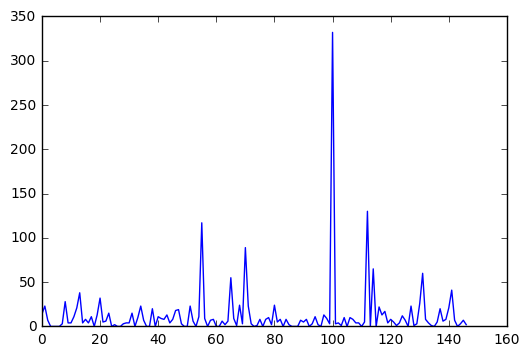

In [82]:
import matplotlib.pyplot as plt
import numpy as np

len_vector = []

for domain in data.keys():
    try:
        len_vector.append(len(data[domain]['links']))
    except:
        pass

mean = np.mean(len_vector)
std = np.std(len_vector)
print "Mean:", mean
print "Std:", std

plt.plot(len_vector)
plt.show()

New Mean: 16.5438596491
New Std: 35.7324709451


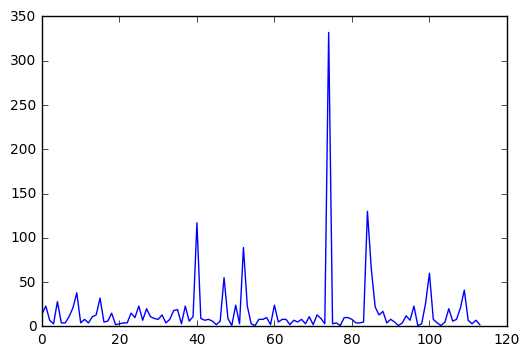

In [83]:
len_vector_0_less = [x for x in len_vector if x != 0]
len_vector_0_less

new_mean = np.mean(len_vector_0_less)
new_std = np.std(len_vector_0_less)
print "New Mean:", new_mean
print "New Std:", new_std


plt.plot(len_vector_0_less)
plt.show()

/home/wou/jupyterNotebook/env/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


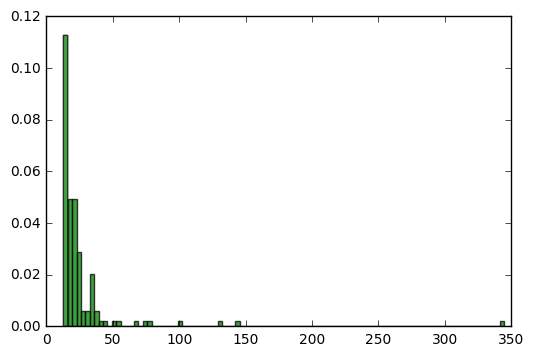

In [90]:
x = mean + std * len_vector

n, bins, patches = plt.hist(x, 100, normed=1, facecolor='g', alpha=0.75)


plt.show()

/home/wou/jupyterNotebook/env/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


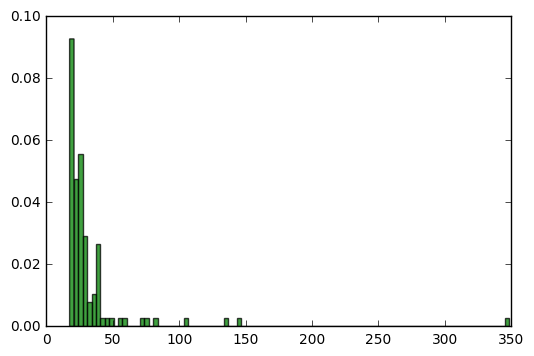

In [85]:
x = new_mean + new_std * len_vector_0_less

n, bins, patches = plt.hist(x, 100, normed=1, facecolor='g', alpha=0.75)


plt.show()